In [4]:
# -----------------------------
# Setup: Import Libraries
# -----------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# -----------------------------
# 1) POLICE MODEL
# Using homicide data (database.csv) to predict monthly homicide counts
# -----------------------------
# Load homicide data (assumes columns named "Year" and "Month" exist)
homicide_df = pd.read_csv('data/database.csv')

# Convert text months (e.g., "June") to numeric (e.g., 6)
month_mapping = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}
homicide_df['Month'] = homicide_df['Month'].map(month_mapping)

# Group by Year and Month to get homicide counts
monthly_counts = homicide_df.groupby(['Year', 'Month']).size().reset_index(name='homicide_count')

# Use Year and Month as features
X_police = monthly_counts[['Year', 'Month']]
y_police = monthly_counts['homicide_count']

# Split and train a linear regression model
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_police, y_police, test_size=0.2, random_state=42)
police_model = LinearRegression()
police_model.fit(X_train_p, y_train_p)
preds_police = police_model.predict(X_test_p)
mse_police = mean_squared_error(y_test_p, preds_police)
print("Police Model MSE:", mse_police)


# -----------------------------
# 2) BANK MODEL
# Predicting house prices using Ames housing data (train.csv)
# -----------------------------
house_df = pd.read_csv('data/house-prices-advanced-regression-techniques/train.csv')

# For demonstration, add a dummy crime feature (in practice, you'd merge actual crime data)
np.random.seed(42)
house_df['local_crime_rate'] = np.random.uniform(0, 10, len(house_df))

# Use only numeric features for simplicity and fill missing values with 0
features_bank = house_df.select_dtypes(include=[np.number]) \
                        .drop(columns=['SalePrice'], errors='ignore') \
                        .fillna(0)
target_bank = house_df['SalePrice']

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(features_bank, target_bank, test_size=0.2, random_state=42)
bank_model = GradientBoostingRegressor(random_state=42)
bank_model.fit(X_train_b, y_train_b)
preds_bank = bank_model.predict(X_test_b)
mse_bank = mean_squared_error(y_test_b, preds_bank)
print("Bank Model MSE:", mse_bank)


# -----------------------------
# 3) COMBINED MODEL
# Merge homicide data with house prices by Neighborhood
# (We simulate Neighborhood in the homicide data if it doesn't exist)
# -----------------------------
# List of Ames neighborhoods (from data labels)
neighborhoods = [
    "Blmngtn","Blueste","BrDale","BrkSide","ClearCr","CollgCr","Crawfor","Edwards","Gilbert","IDOTRR",
    "MeadowV","Mitchel","Names","NoRidge","NPkVill","NridgHt","NWAmes","OldTown","SWISU","Sawyer",
    "SawyerW","Somerst","StoneBr","Timber","Veenker"
]

# If homicide_df doesn't have 'Neighborhood', randomly assign one for the example
if 'Neighborhood' not in homicide_df.columns:
    np.random.seed(42)
    homicide_df['Neighborhood'] = np.random.choice(neighborhoods, size=len(homicide_df))

# Compute crime count per neighborhood
crime_by_neighborhood = homicide_df.groupby('Neighborhood').size().reset_index(name='crime_count')

# Merge crime data into the house price data on 'Neighborhood'
combined_df = pd.merge(house_df, crime_by_neighborhood, on='Neighborhood', how='left')
combined_df['crime_count'] = combined_df['crime_count'].fillna(0)  # no homicides => 0

# Use numeric features (including crime_count) and fill missing values with 0
features_combined = combined_df.select_dtypes(include=[np.number]) \
                               .drop(columns=['SalePrice'], errors='ignore') \
                               .fillna(0)
target_combined = combined_df['SalePrice']

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(features_combined, target_combined, 
                                                            test_size=0.2, random_state=42)
combined_model = GradientBoostingRegressor(random_state=42)
combined_model.fit(X_train_c, y_train_c)
preds_combined = combined_model.predict(X_test_c)
mse_combined = mean_squared_error(y_test_c, preds_combined)
print("Combined Model MSE:", mse_combined)


/var/folders/cd/vmj840453cz603ygrc6my4300000gn/T/ipykernel_15095/2718198771.py:17: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  homicide_df = pd.read_csv('data/database.csv')


Police Model MSE: 31116.28337248577
Bank Model MSE: 798874699.7636172
Combined Model MSE: 831533914.9341652


/var/folders/cd/vmj840453cz603ygrc6my4300000gn/T/ipykernel_15095/285069901.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=neighborhood_prices.index, y=neighborhood_prices.values, palette='viridis')


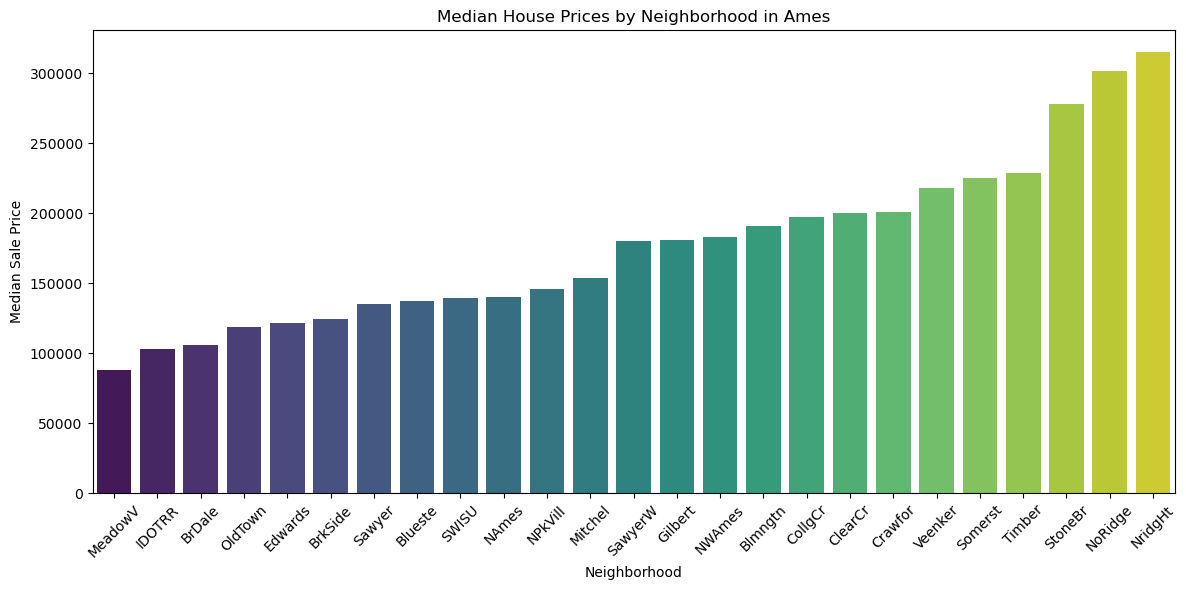

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Ames housing data from the provided folder structure
house_df = pd.read_csv('data/house-prices-advanced-regression-techniques/train.csv')

# Group the data by Neighborhood and calculate the median SalePrice
neighborhood_prices = house_df.groupby('Neighborhood')['SalePrice'].median().sort_values()

# Set up the visualization
plt.figure(figsize=(12,6))
sns.barplot(x=neighborhood_prices.index, y=neighborhood_prices.values, palette='viridis')
plt.xticks(rotation=45)
plt.xlabel('Neighborhood')
plt.ylabel('Median Sale Price')
plt.title('Median House Prices by Neighborhood in Ames')
plt.tight_layout()
plt.show()
